# Exercise Tasks

## Part I: Data Acquisition and Loading 
1. Choose a subreddit of your choice. Preferably something of interest to you. 
1. Conceptualize a database design that can collect the data.
    * Make sure your items (posts) are unique and not duplicated!
    * Make sure you capture at least title, author, subreddit, tags, title link, and timestamp
    * Along with the metadata, capture all the text into one or more data field(s) suitable for information retrieval
    * Write triggers for auto updates of IR related fields
    * Add index (either GIN or GiST) for the IR related fields
    * Additionally, design a field to hold:
        * Sentiment
1. Implement the database in your PostgreSQL schema
1. Implement cells of Python Code that 
    * collect the latest posts from a subreddit of your choice (**should be text-dominant not image/video**), 
    * processes the messages to extract metadata, 
    * process the text for IR, and 
    * perform computational linguistics (i.e, extract sentiment scores), 
    * then insert the data into your database.
1. After you have loaded data from a subreddit, choose a few more subreddits and load those!

## Part II: Analytics 

1. Write some test queries following the text vectors from Module 7.
1. Produce **interesting visualizations** of the linguistic data.
    * Try to look for trends (within a subreddit) and variations of topics across subreddits
    * Some comparative plots across feeds
1. Write a summary of your findings!

 
 

# Part II: Analytics 

## Task 7: Write some test queries to validate the text vector(s) (see Module 7).

**Insert more cells if required**

**If you haven't done in Part I:** 
To prepare your DB to be read, you will need to grant the dsa_ro_user schema access and select privileges on your table.

```SQL
GRANT USAGE ON SCHEMA <your schema> TO dsa_ro_user;  -- NOTE: change to your schema
GRANT SELECT ON <your table> TO dsa_ro_user;
```

In [1]:
## Your code in this cell
## ------------------------
import getpass
import psycopg2
import numpy as np
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
mypasswd = getpass.getpass()

········


In [2]:
mysso = 'jsmm8'
dbname = 'dsa_student'
schema = 'jsmm8'

from psycopg2.extensions import adapt, register_adapter, AsIs

connection = psycopg2.connect(database = dbname, 
                              user = mysso, 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

In [3]:
## Your code in this cell
## ------------------------
select_query = """
SELECT post_id, title, author, subreddit, timestamp, processed_body, sentiment
FROM jsmm8.data_science_posts
LIMIT 10;
"""

df = pd.read_sql_query(select_query, connection)
df.head()

,post_id,title,author,subreddit,timestamp,processed_body,sentiment
0,1fxz22n,Weekly Entering & Transitioning - Thread 07 Oc...,AutoModerator,datascience,2024-10-06 23:01:31,\n\nWelcome to this week's entering & transit...,positive
1,1fzswk1,I created a 6-week SQL for data science roadma...,avourakis,datascience,2024-10-09 09:36:10,I created this roadmap to guide you through ma...,positive
2,1g01l33,SQL queries that group by number,coronnial,datascience,2024-10-09 15:41:19,I wanted to know if generally people use group...,negative
3,1fzw393,"Need help on analysis of AI performance, compu...",PianistWinter8293,datascience,2024-10-09 11:50:22,,neutral
4,1g07nvw,I linked AI Performance Data with Compute Size...,PianistWinter8293,datascience,2024-10-09 20:27:28,,neutral


In [4]:
query = """
SELECT post_id, title, author, subreddit, timestamp, processed_body, sentiment
FROM jsmm8.data_science_posts
WHERE to_tsvector('english', processed_body) @@ to_tsquery('machine & learning');
"""

df_machine_learning = pd.read_sql_query(query, connection)
df_machine_learning.head()

,post_id,title,author,subreddit,timestamp,processed_body,sentiment
0,1fzh90w,Which position should I join? (Palantir Develo...,naive_byes,datascience,2024-10-08 21:26:32,I have recently received two offers from two d...,negative
1,1fy9jfq,We are not only model builders! Stop with that!,EducationalUse9983,datascience,2024-10-07 09:51:47,I would like to share some thoughts I’ve been ...,positive
2,1fpwg53,Suggestions for Unique Data Engineering/Scienc...,No-Brilliant6770,datascience,2024-09-26 08:40:17,"Hey everyone,\n\nI'm looking for some project ...",positive
3,1foo5j6,Any of you moved from data science role to MLE...,Muted_Standard175,datascience,2024-09-24 16:38:21,I want to change from a data science role to m...,negative
4,1fhli34,My path into Data/Product Analytics in big tec...,productanalyst9,datascience,2024-09-15 14:53:02,"Hey folks,\n\nI'm a Sr. Analytics Data Scienti...",positive


In [5]:
analyzer = SentimentIntensityAnalyzer()

df_machine_learning['pos'] = df_machine_learning['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
df_machine_learning['neg'] = df_machine_learning['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
df_machine_learning['neu'] = df_machine_learning['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['neu'])

## Task 8: Produce interesting visualizations of the lingustic data.

 * Examples:
     * Try to look for trends (within a subreddit)
     * Topic variations across subreddits 
     * Some comparative plots across subreddits 


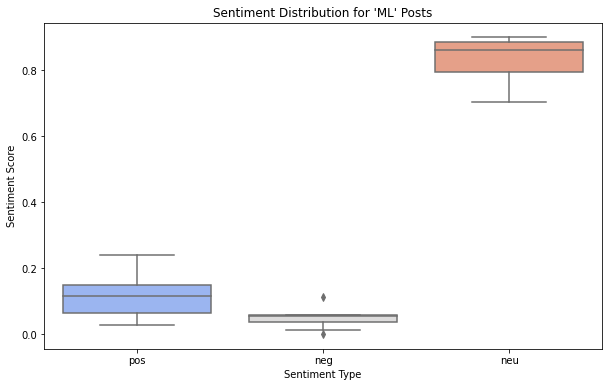

In [6]:
## Your code in this cell
## ------------------------
df_melted = pd.melt(df_machine_learning[['pos', 'neg', 'neu']], 
                    var_name='Sentiment Type', 
                    value_name='Sentiment Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment Type', y='Sentiment Score', data=df_melted, palette='coolwarm')
plt.title("Sentiment Distribution for 'ML' Posts")
plt.xlabel("Sentiment Type")
plt.ylabel("Sentiment Score")
plt.show()

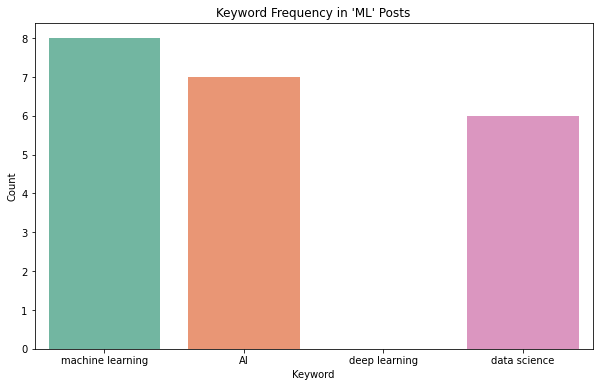

In [7]:
keywords = ['machine learning', 'AI', 'deep learning', 'data science']
keyword_counts = {keyword: df_machine_learning['processed_body'].str.contains(keyword, case=False).sum() for keyword in keywords}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()), palette='Set2')
plt.title("Keyword Frequency in 'ML' Posts")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.show()

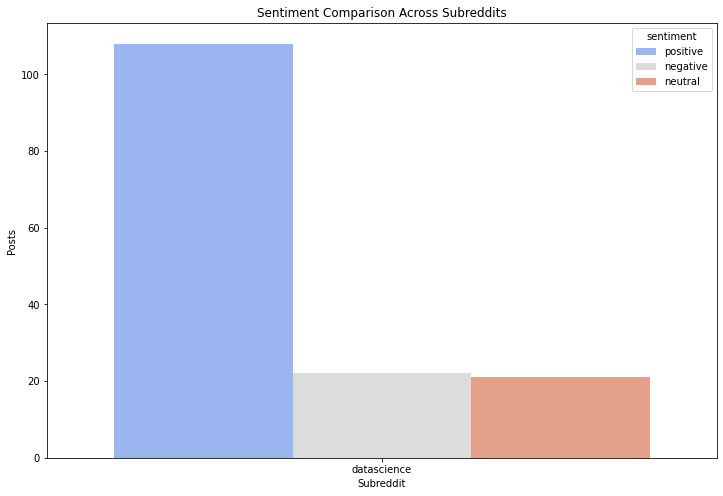

In [8]:
select_query_subreddits = """
SELECT post_id, title, author, subreddit, timestamp, processed_body, sentiment
FROM jsmm8.data_science_posts
WHERE subreddit IN ('datascience', 'machinelearning', 'artificial');
"""

df_multiple_subreddits = pd.read_sql_query(select_query_subreddits, connection)

plt.figure(figsize=(12, 8))
sns.countplot(x='subreddit', hue='sentiment', data=df_multiple_subreddits, palette='coolwarm')
plt.title("Sentiment Comparison Across Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("Posts")
plt.show()

In [9]:
analyzer = SentimentIntensityAnalyzer()
df['compound'] = df['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

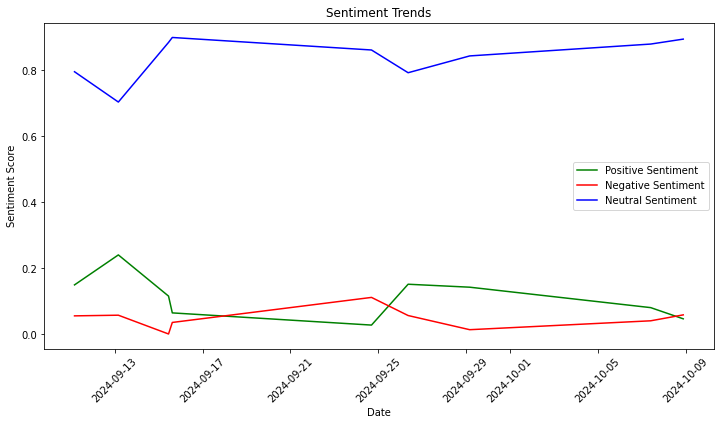

In [10]:
df_machine_learning['timestamp'] = pd.to_datetime(df_machine_learning['timestamp'])

plt.figure(figsize=(12, 6))

sns.lineplot(x='timestamp', y='pos', data=df_machine_learning, label='Positive Sentiment', color='green')
sns.lineplot(x='timestamp', y='neg', data=df_machine_learning, label='Negative Sentiment', color='red')
sns.lineplot(x='timestamp', y='neu', data=df_machine_learning, label='Neutral Sentiment', color='blue')

plt.title("Sentiment Trends")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [11]:
connection.commit()
connection.close()

## Task 9: Write a summary of your findings!


# Save your notebook, then `File > Close and Halt`

---